In [84]:
import requests
import networkx
import numpy as np
import time
import json
from tqdm.notebook import tqdm, tnrange
import collections
import math
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [ ]:
authorize_url = 'https://oauth.vk.com/authorize?client_id=7393173&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=code&v=5.103'
print(authorize_url)
access_code = 'INSERT'
token_response = requests.get('https://oauth.vk.com/access_token', params={
    'client_id': 7393173, 'client_secret': 'INSERT',
    'redirect_uri': 'https://oauth.vk.com/blank.html', 'code': access_code,
})

In [ ]:
print(token_response.json())

In [ ]:
# Semi-manually copypasted, but already obsolete
access_token = 'INSERT'
my_user_id = 71473529

In [ ]:
def get_friends_ids(user_id):
    friends_url = 'https://api.vk.com/method/friends.get?user_id={}&access_token={}&v=5.103' 
    json_response = requests.get(friends_url.format(user_id, access_token)).json()
    if json_response.get('error'):
        print('User {}:'.format(user_id))
        print(json_response.get('error'))
        return []
    return json_response['response']['items']

def get_name(user_id):
    users_url = 'https://api.vk.com/method/users.get?user_id={}&access_token={}&v=5.103'
    json_response = requests.get(users_url.format(user_id, access_token)).json()
    if json_response.get('error'):
        print('User {}:'.format(user_id))
        print(json_response.get('error'))
        return '<ERROR>'
    data = json_response['response'][0]
    return '{} {}'.format(data['first_name'], data['last_name'])

def get_attributes(user_id):
    users_url = 'https://api.vk.com/method/users.get?user_id={}&access_token={}&v=5.103&fields=city,sex'
    json_response = requests.get(users_url.format(user_id, access_token)).json()
    if json_response.get('error'):
        print('User {}:'.format(user_id))
        print(json_response.get('error'))
        return {}
    data = json_response['response'][0]
    city = data.get('city') and data.get('city')['title']
    sex = {1: 'female', 2: 'male'}.get(data.get('sex'), '<UNKNOWN')
    return {'city': (city or '<UNKNOWN>'), 'sex': sex}

In [ ]:
graph = {}
friend_ids = get_friends_ids(my_user_id)
for friend_id in tqdm(friend_ids):
    graph[friend_id] = get_friends_ids(friend_id)
    time.sleep(0.5)

In [ ]:
id_to_name = {}
for user_id in tqdm(graph):
    id_to_name[user_id] = get_name(user_id)
    time.sleep(0.5)

In [ ]:
G = networkx.Graph(directed=False)

In [ ]:
for i in tqdm(graph):
    attributes = get_attributes(i)
    G.add_node(id_to_name[i], **attributes)
    for j in graph[i]:
        if i != j and i in friend_ids and j in friend_ids:
            G.add_edge(id_to_name[i], id_to_name[j])
    time.sleep(0.5)

In [2]:
# G = nx.read_graphml('graph.graphml')  # run from here if do not want to download data from VK.com

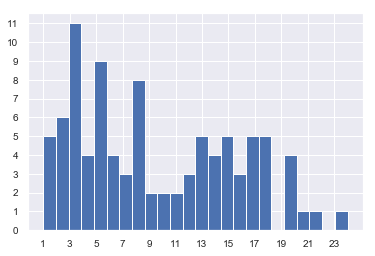

In [4]:
import seaborn as sns
sns.set()
degrees = dict(G.degree).values()
bins = max(degrees) - min(degrees) + 1
plt.hist(degrees, bins=bins)
plt.xticks(range(min(degrees), max(degrees)+1, 2), fontsize=10)
plt.yticks(range(0, 12), fontsize=10)
print()

In [6]:
components = [G.subgraph(nodes) for nodes in nx.connected_components(G)]

In [12]:
print('DIAMETER:', nx.diameter(components[0]))  # second component is a full graph of 5 nodes

DIAMETER: 9


In [13]:
print('AVERAGE CLUSTERING COEF:', nx.algorithms.cluster.average_clustering(G))

AVERAGE CLUSTERING COEF: 0.6583202298129415


In [199]:
def argmax(dictionary):
    key = None
    value = None
    for k, v in dictionary.items():
        if key is None or v > value:
            key, value = k, v
    return key

In [200]:
degree_centrality = nx.algorithms.degree_centrality(G)
for index in G.nodes:
    G.nodes[index]['degree_centrality'] = degree_centrality[index]
best_node = argmax(degree_centrality)
print('{}: deg_centr={}'.format(best_node, degree_centrality[best_node]))
closeness_centrality = nx.algorithms.closeness_centrality(G)
for index in G.nodes:
    G.nodes[index]['closeness_centrality'] = closeness_centrality[index]
best_node = argmax(closeness_centrality)
print('{}: closeness_centr={}'.format(best_node, closeness_centrality[best_node]))
betweenness_centrality = nx.algorithms.betweenness_centrality(G)
for index in G.nodes:
    G.nodes[index]['betweenness_centrality'] = betweenness_centrality[index]
best_node = argmax(betweenness_centrality)
print('{}: betweenness_centr={}'.format(best_node, betweenness_centrality[best_node]))
pagerank = nx.algorithms.pagerank(G)
for index in G.nodes:
    G.nodes[index]['pagerank'] = pagerank[index]
best_node = argmax(pagerank)
print('{}: pagerank={}'.format(best_node, pagerank[best_node]))

Михаил Флоринский: deg_centr=0.2608695652173913
Алина Щукина: closeness_centr=0.34651424287856075
Соня Хегай: betweenness_centr=0.3952904238618524
Алина Щукина: pagerank=0.024073123882338066


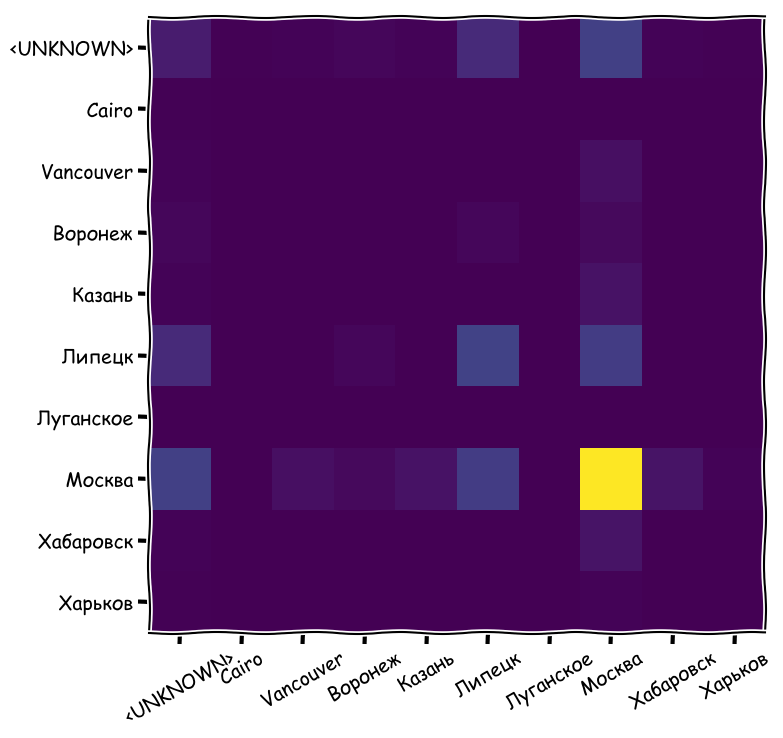

In [19]:
mixing_dict = nx.attribute_mixing_dict(G, 'city')
attributes = sorted(mixing_dict.keys())
mixing_matrix = np.array([[mixing_dict[a].get(b, 0) for b in attributes] for a in attributes])
plt.figure(figsize=(8, 8))
plt.xticks(list(range(len(attributes))), attributes, rotation=30)
plt.yticks(list(range(len(attributes))), attributes)
plt.imshow(mixing_matrix)

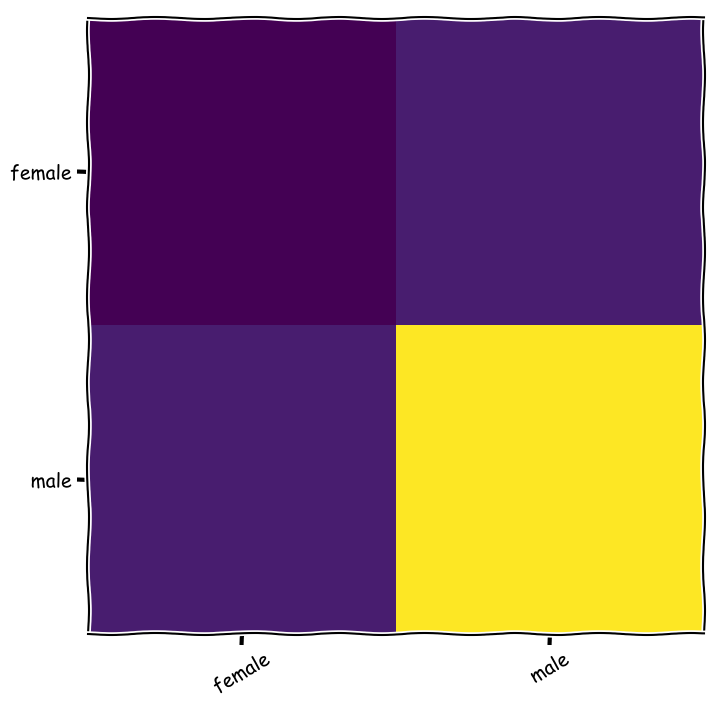

In [20]:
mixing_dict = nx.attribute_mixing_dict(G, 'sex')
attributes = sorted(mixing_dict.keys())
mixing_matrix = np.array([[mixing_dict[a].get(b, 0) for b in attributes] for a in attributes])
plt.figure(figsize=(8, 8))
plt.xticks(list(range(len(attributes))), attributes, rotation=30)
plt.yticks(list(range(len(attributes))), attributes)
plt.imshow(mixing_matrix)

In [21]:
mixing_matrix

array([[148, 168],
       [168, 398]])

In [22]:
import scipy.spatial as spt
from networkx.utils import cuthill_mckee_ordering, reverse_cuthill_mckee_ordering

def draw_structure(G, apply_reordering=True):
    if not isinstance(G, np.ndarray):
        if apply_reordering:
            rcm = list(reverse_cuthill_mckee_ordering(G))
        else:
            rcm = list(G.nodes)
        A = nx.adjacency_matrix(G, nodelist=rcm).todense()
    else:
        A = G

    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, interpolation='None')
    ax[0, 0].set_title('Adjacency Matrix')

    D = np.corrcoef(A)
    ax[1, 0].imshow(D, interpolation='None')
    ax[1, 0].set_title('Correlation coeff.')

    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, interpolation='None')
    ax[0, 1].set_title('Euclidean Dist.')

    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, interpolation='None')
    ax[1, 1].set_title('Cosine Dist.')

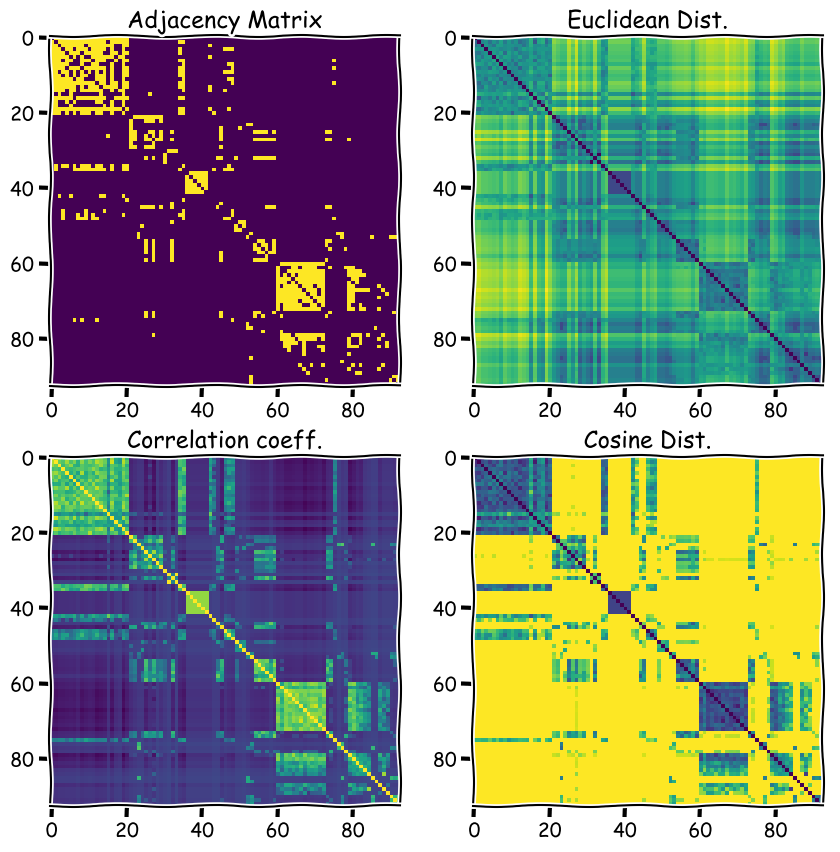

In [23]:
draw_structure(G, apply_reordering=False)

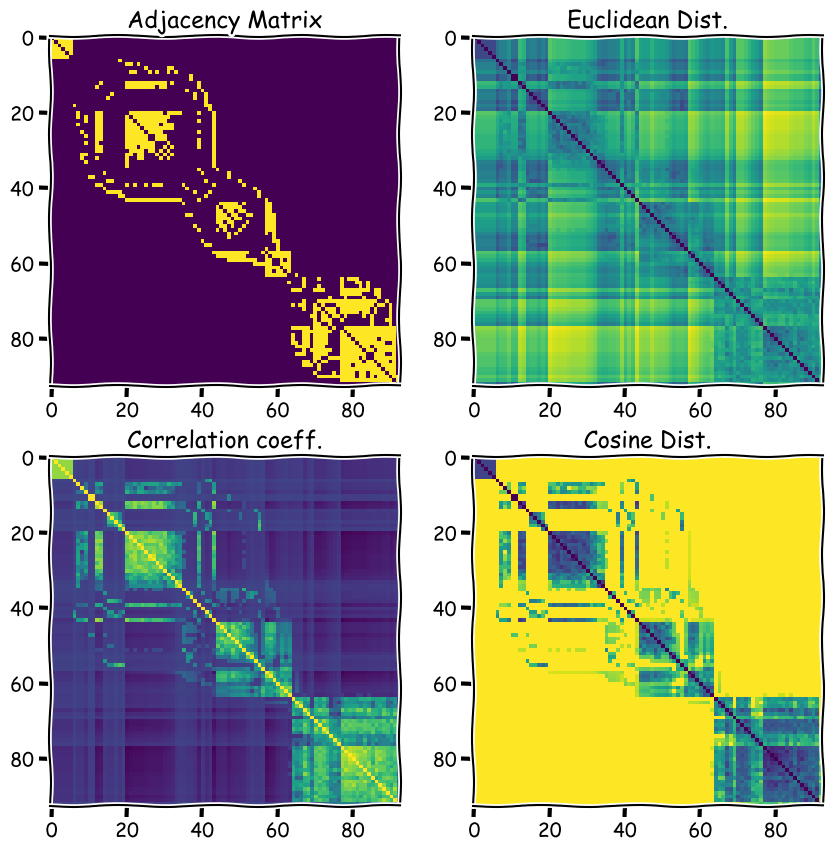

In [24]:
draw_structure(G)

In [28]:
cliques = list(nx.find_cliques(G))
cliques.sort(key=lambda c: len(c))
print('Largest clique: {} nodes'.format(len(cliques[-1])))
print(', '.join([x for x in cliques[-1]]))
for index in G.nodes:
    G.nodes[index]['in_largest_clique'] = int(index in cliques[-1])

Largest clique: 12 nodes
Михаил Флоринский, Антон Наумов, Валерий Батурин, Лёха Гавриков, Камиль Лотфуллин, Ярослав Ребенко, Сергей Горбачёв, Катя Минеева, Никита Нестеров, Евгений Правда, Никита Ширин, Александр Чернявский


In [30]:
import community
partition_louvain = community.best_partition(G)
for index in G.nodes:
    G.nodes[index]['partition_louvain'] = partition_louvain[index]
    
sorted_matrix = nx.adj_matrix(G, nodelist=sorted(G.nodes, key=lambda x:partition_louvain[x])).todense()
draw_structure(sorted_matrix)               

In [32]:
def MCL(A, tol, p, alpha):
    T = A / A.sum(axis=0)[np.newaxis, :]
    M = T
    while(True):
        # Expansion:
        M1 = np.linalg.matrix_power(M, p)
        # Inflation:
        M1 = np.power(M1, alpha)
        M1 = M1 / M1.sum(axis=0)[np.newaxis, :]
        M1[M1<=tol] = 0
        if np.linalg.norm(M - M1) == 0:
            return M1
        else:
            M = M1.copy()

In [33]:
index_to_label = {i: label for (i, label) in enumerate(G.nodes)}
label_to_index = {label: i for (i, label) in enumerate(G.nodes)}
matrix = np.asarray(nx.adj_matrix(G).todense())
mcl_matrix = MCL(matrix, 0.01, 2, 2)
mcl_clusters = list(mcl_matrix.argmax(axis=0))
for i in range(len(mcl_clusters)):
    G.nodes[index_to_label[i]]['partition_mcl'] = mcl_clusters[i]
    
sorted_matrix = nx.adj_matrix(G, nodelist=sorted(G.nodes, key=lambda x:mcl_clusters[label_to_index[x]])).todense()
draw_structure(sorted_matrix)   

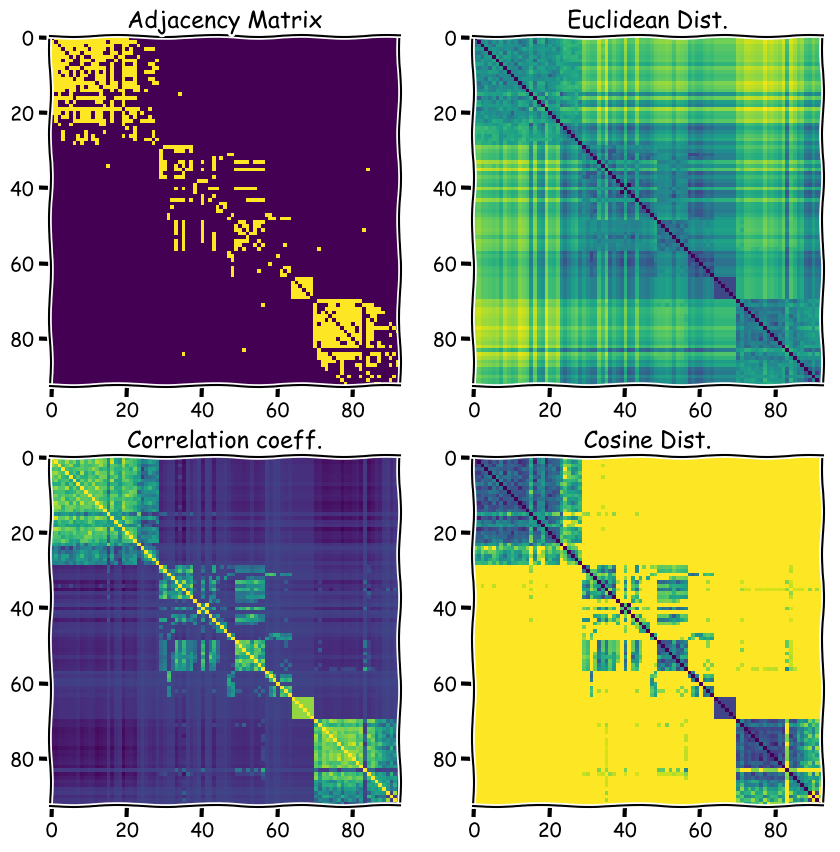

In [36]:
import igraph as ig
iG = ig.read('graph.graphml',format='graphml')
igraph_clustering = iG.community_edge_betweenness(directed=False).as_clustering()
vertex_to_cluster = {}
for i, cluster in enumerate(igraph_clustering):
    for v in cluster:
        vertex_to_cluster[v] = i
for v, cluster in vertex_to_cluster.items():
    G.nodes[iG.vs[v]['id']]['partition_edge_betweenness'] = cluster
    
sorted_matrix = nx.adj_matrix(G, nodelist=sorted(G.nodes, key=lambda x: G.nodes[x]['partition_edge_betweenness'])).todense()
draw_structure(sorted_matrix)   

In [38]:
nx.write_graphml(G, 'network_attributes.graphml')  # for Gephi